In [1]:
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Walkthrough
The data for this project comes from many sources (see the dissertation for full citations.) All of the data has been aggregated into monthly means over time and compiled into one place. The data is processed using weighted means (over space) and taking the trend. This data walkthrough explains these two processing steps, and has code that can be copy/pasted at the end to use all of the data.

## Weighted Mean
Many of the datasets are gridded, and the project needs aggregated mean for the Northern Exatropics, Tropics, and Southern Exatraopics. A simple mean across will not suffice because latitude & longitude grids distort area (thus a simple mean would bias toward the poles). 

The weight calculations are based on on [this](http://xarray.pydata.org/en/stable/examples/area_weighted_temperature.html) tutorial from `xarray`. The function is found in the repo at `core.data.file_processing.take_weighted_mean()`.

In [45]:
# Open file & standardize names
land_filename = "core/data/weather/temp/CRUTEM.5.0.1.0.alt.anomalies.nc"
ds = xr.open_dataset(land_filename)
ds = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
da = ds.tas  # Extract the relevant variable for processing

Generate the weights and weighted data array:

In [46]:
# Area is proportional to cosine of latitude, so these are the weights:
weights = np.cos(np.deg2rad(da.lat))
weights.name = "weights"

In three sections for the three different regions, take the weighted average:

In [47]:
# Subset the desired reagion by latitude:
s_ext = da.sel(lat=slice(-90, -30))

# Create the weighted dataarray:
weighted_s_ext = s_ext.weighted(weights)

# Take the mean:
s_ext_mean = weighted_s_ext.mean(['lon', 'lat'], skipna=True)

# Name the region
s_ext_mean.name = "south_exatropics"

# Repeat for the two other regions (could put in a for loop, but it's clear this way)
tropics = da.sel(lat=slice(-30, 30))
weighted_tropics = tropics.weighted(weights)
tropics_mean = weighted_tropics.mean(['lon', 'lat'], skipna=True)
tropics_mean.name = "tropics"

n_ext = da.sel(lat=slice(30, 90))
weighted_n_ext = n_ext.weighted(weights)
n_ext_mean = weighted_n_ext.mean(['lon', 'lat'], skipna=True)
n_ext_mean.name = "north_exatropics"

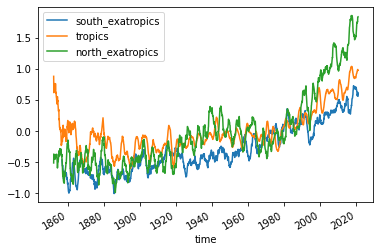

In [48]:
# Merge all the data
all_das = xr.merge([s_ext_mean, tropics_mean, n_ext_mean])

# Plot the rolling means
all_das.to_dataframe().rolling(window=24).mean().plot()
plt.show()

## Removing Seasonal Trends & Noise
In this project we are specifically interested in interannual variability (IAV). 

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [50]:
df = df_no_na
df.index = pd.to_datetime(df.index)

Using the imported data from above, we will decompose one variable using [`statsmodel.tsa.seasonal.seasonal_decompose`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html). Using an addative method.

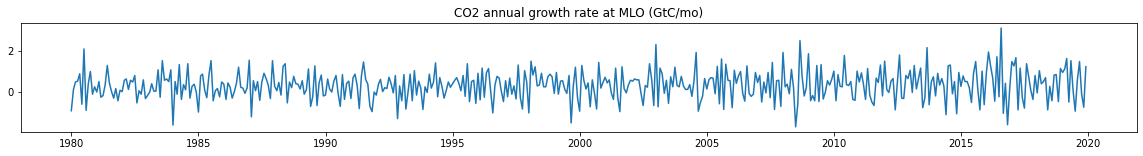

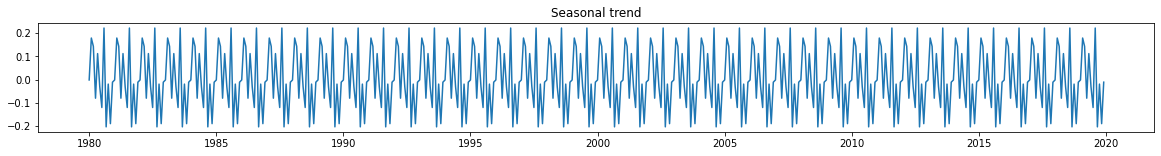

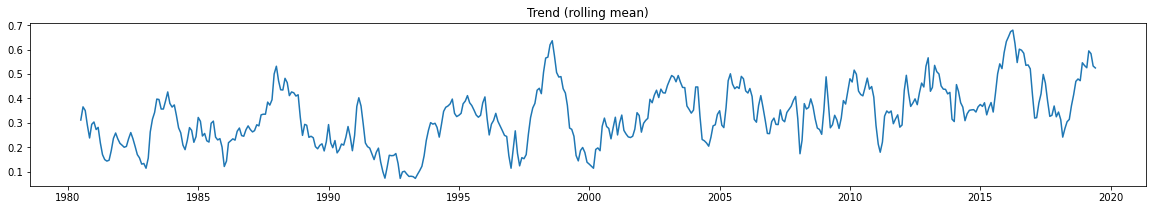

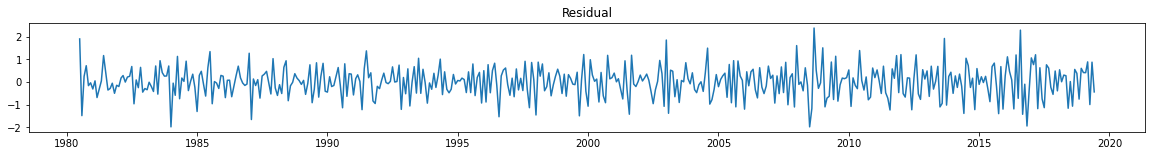

In [51]:
decompose_result = seasonal_decompose(df['CO2_gr_MLO'], model="additive", period=12)
plt.figure(figsize=(20,2))
plt.title("CO2 annual growth rate at MLO (GtC/mo)")
plt.plot(df.index, decompose_result.observed)
plt.show()

plt.figure(figsize=(20,2))
plt.title("Seasonal trend")
plt.plot(decompose_result.seasonal)
plt.show()

plt.figure(figsize=(20,3))
plt.title("Trend (rolling mean)")
plt.plot(decompose_result.trend)
plt.show()

plt.figure(figsize=(20,2))
plt.title("Residual")
plt.plot(decompose_result.resid)
plt.show()

## Data Pipeline
Here is the data pipeline from beginning to end. This pipeline aggregates all the data, performs weighted mean calculations when relevant, and returns the trend for all variables.

In [10]:
from core.data.file_processing import open_all_data, generate_all_monthly_data
from core.data.data_processing import trend

# To regenerate the data, run:
# generate_all_monthly_data()
df = open_all_data()
df_no_na = df.dropna()
df_no_na.index = pd.to_datetime(df_no_na.index).to_period("M")
df_iav = trend(df_no_na)

In [11]:
df_iav.columns

Index(['CO2_ppm_MLO', 'CO2_ppm_SPO', 'CO2_gr_MLO', 'CO2_gr_SPO',
       'CO2_ppm_global', 'land_sink_GL', 'land_sink_NHex', 'land_sink_TR',
       'land_sink_SHex', 'ocean_sink_GL', 'ocean_sink_NHex', 'ocean_sink_TR',
       'ocean_sink_SHex', 'Landtemp_GL', 'Landtemp_SHex', 'Landtemp_TR',
       'Landtemp_NHex', 'sst_GL', 'sst_SHex', 'sst_TR', 'sst_NHex', 'Pre_GL',
       'Pre_SHex', 'Pre_TR', 'Pre_NHex', 'WSPD_GL', 'WSPD_SHex', 'WSPD_TR',
       'WSPD_NHex', 'ENSO', 'ffco2_GL', 'ffco2_NH', 'ffco2_SH', 'ffco2_NHex',
       'ffco2_TR', 'ffco2_SHex'],
      dtype='object')

# Calculate inferred land sink
- Fossil fuels: data from gridfed
    - Converting from Kg CO2/month to GtC/month, Calculated using (GridFED gl)/1000000000000/3.67

- LUC -- from BLUE
    - Units in gt/c; distributed over year evenly per month

- Monthly growth rate. From NOAA data 
    - Used global monthly ppm; took derative; converted from ppm to gt/c / month

- Ocean sink
    - Multi-model average, gt/c 

CO2 atmospheric growth rate = FF + LUC - (land sink + ocean sink). 

Therefore, the inferred land sink is:

Land sink = FF + LUC - (Ocean sink + AGR)

In [2]:
from core.data.file_processing import inferred_land_sink

In [26]:
df_inf = inferred_land_sink()
df_inf = df_inf.dropna()
df_inf['Inferred_land_sink'] = df_inf['GL_ff_emissions'] \
                             + df_inf['LUC'] \
                             - df_inf['monthly_gr'] \
                             + df_inf['ocean_sink_GL'] # because already negative
df_inf['Inferred_land_sink'] = -1 * df_inf['Inferred_land_sink']
df_inf.resample('Y').sum().head()

,GL_ff_emissions,LUC,monthly_gr,ocean_sink_GL,Inferred_land_sink
Date,,,,,
1980,4.743143,1.097391,2.3108,-1.152000,-2.377734
1981,5.131920,1.212406,2.3320,-1.240556,-2.771770
1982,5.096619,1.213705,2.2048,-1.258111,-2.847413
1983,5.142780,1.244570,3.6464,-1.368889,-1.372061
1984,5.298297,1.278482,3.2224,-1.358111,-1.996268


In [27]:
df_inf_iav = trend(df_inf)

## Compare Inferred Land Sink & Multi-model DGVM average

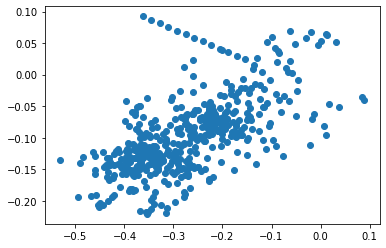

In [28]:
plt.plot(df_inf_iav['Inferred_land_sink'], df_iav.iloc[1:]['land_sink_GL'], linestyle="", marker="o")

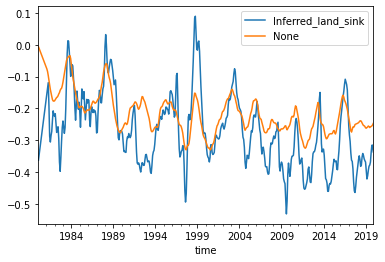

In [30]:
df_inf_iav['Inferred_land_sink'].plot()
(df_iav.iloc[1:]['land_sink_GL'] - df_inf_iav['LUC']).plot()
plt.legend()

## Compare to GCB

In [31]:
gcb = pd.read_csv('core/data/sink/gcp_modelavg.csv')
gcb.index = pd.to_datetime(gcb['Year'], format="%Y")
gcb.index = gcb.index.to_period("Y")
del gcb['Year']

In [32]:
gcb['inferred'] = df_inf_iav['Inferred_land_sink'].resample("Y").sum()
gcb['monthly_DGVM_avg'] = (df_iav['land_sink_GL'][1:] -df_inf_iav['LUC']).resample("Y").sum()
#gcb['monthly_DGVM_avg'] = (df_iav['land_sink_GL'][1:]).resample("Y").sum()

df_inf['Inferred_land_sink'].rolling(window=12, center=False).sum()
gcb['GCB'] = -1 * gcb['GCB']
gcb = gcb.dropna()

<AxesSubplot:xlabel='Year'>

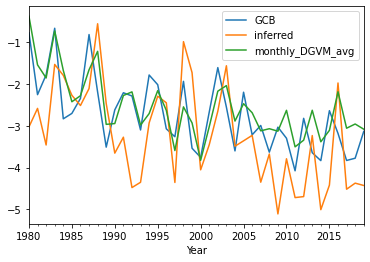

In [33]:
gcb.plot()

In [34]:
gcb.corr()

,GCB,inferred,monthly_DGVM_avg
GCB,1.000000,0.478296,0.782331
inferred,0.478296,1.000000,0.650436
monthly_DGVM_avg,0.782331,0.650436,1.000000


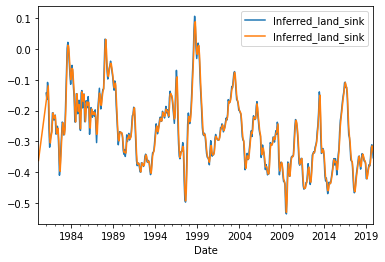

In [35]:
df_inf['Inferred_land_sink'].rolling(window=12, center=False).mean().plot()
df_inf_iav['Inferred_land_sink'].plot()
plt.legend()

## FFTs

In [88]:
import tensorflow as tf

<AxesSubplot:xlabel='Date'>

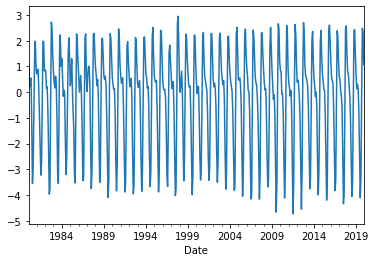

In [87]:
df_inf['Inferred_land_sink'].plot()

In [94]:
df_inf

,GL_ff_emissions,LUC,monthly_gr,ocean_sink_GL,Inferred_land_sink
Date,,,,,
1980-02,0.473885,0.052005,1.4840,-0.067333,1.025443
1980-03,0.479382,0.052005,0.6784,-0.066667,0.213680
1980-04,0.432896,0.052005,0.8480,-0.080333,0.443432
1980-05,0.408852,0.052005,0.9116,-0.101111,0.551854
1980-06,0.364041,0.052005,-0.9328,-0.098222,-1.250624
...,...,...,...,...,...
2019-08,0.754126,0.082750,-2.6076,-0.148778,-3.295698
2019-09,0.777638,0.082750,0.5936,-0.163333,-0.103455
2019-10,0.855558,0.082750,3.2224,-0.199556,2.483647


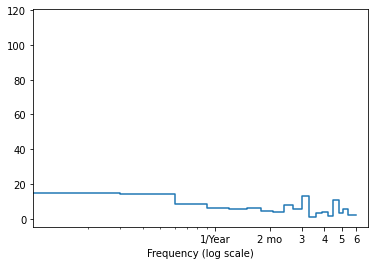

In [107]:
var_for_fft = gcb['inferred']

fft = tf.signal.rfft(var_for_fft)
f_per_dataset = np.arange(0, len(fft))

n_samples = len(var_for_fft)
months_per_year = 12
years_per_dataset = n_samples/(months_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
#plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 2, 3, 4, 5, 6], labels=['1/Year', '2 mo', '3', '4', '5', '6'])
_ = plt.xlabel('Frequency (log scale)')

In [96]:
fft

<tf.Tensor: shape=(240,), dtype=complex64, numpy=
array([ 2.90774597e+02-1.59308314e-04j,  6.81289101e+00+3.61554070e+01j,
       -4.14630604e+00+1.68010502e+01j,  2.66228616e-01+1.07293844e+01j,
        1.62836790e-01+8.50457287e+00j,  1.05726838e+00+4.99270773e+00j,
        3.31848860e-01+5.70645428e+00j, -1.52446866e-01+5.16160536e+00j,
       -2.00657368e-01+3.52955866e+00j, -1.27373695e-01+3.21068931e+00j,
        2.61240244e-01+3.05430841e+00j, -7.64603734e-01+3.10098934e+00j,
       -4.76574421e-01+2.06912827e+00j, -2.89027631e-01+2.23055363e+00j,
       -1.26752973e-01+2.33527780e+00j, -3.75830114e-01+1.94408524e+00j,
       -3.92267406e-01+1.52120090e+00j, -1.90530479e-01+1.64730275e+00j,
       -3.02842557e-01+1.63612580e+00j, -4.84003633e-01+1.40042317e+00j,
       -7.36887157e-02+1.27367949e+00j, -1.36398047e-01+1.36833858e+00j,
       -3.34543467e-01+1.31345952e+00j, -3.75801921e-01+1.14588726e+00j,
       -1.87549561e-01+1.02005124e+00j, -2.76184887e-01+1.09306884e+00j,
 